In [1]:
from collections import namedtuple
import random
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from brokenaxes import brokenaxes
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from benchmark_pycometh.segmentation.segmentation_comparer import SegmentsComparer, permute_segments, convert_to_cg_index, load_pycometh
from nanoepitools.reference_cpgs import ReferenceCpGs

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")

ground_truth_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt"
gt = pd.read_csv(ground_truth_file, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"], dtype={"chrom":str})
gt_only_diffmet = gt.loc[gt["theta"]!=0].copy()

methylkit_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methylkit/methylkit_segmentation_15x.bed"
methylkit_seg = pd.read_csv(methylkit_seg_file, sep="\t", skiprows=1, usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})

methcp_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/methcp_segments_15x.bed"
methcp_seg = pd.read_csv(methcp_seg_file, sep="\t", usecols=[0,1,2], names=["chrom", "start", "end"], dtype={"chrom":str})

In [3]:
pycometh_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh_15x/segmentation/segmentation_300_16.tsv"
pycometh_seg = load_pycometh(pycometh_seg_file)

pycometh_lw_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh_15x/segmentation/segmentation_600_16.tsv"
pycometh_seg_longwindow = load_pycometh(pycometh_lw_seg_file)


pycometh_8_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh_15x/segmentation/segmentation_300_8.tsv"
pycometh_seg_coarse = load_pycometh(pycometh_8_seg_file)

pycometh_8_lw_seg_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh_15x/segmentation/segmentation_600_8.tsv"
pycometh_seg_coarser = load_pycometh(pycometh_8_lw_seg_file)

In [4]:
sc = SegmentsComparer(gt_segments=gt, predicted_segments={"PycoMeth": pycometh_seg,
                                                          "PycoMeth (random)": permute_segments(pycometh_seg),
                                                          "PycoMeth LW": pycometh_seg_longwindow,
                                                          "PycoMeth LW (random)": permute_segments(pycometh_seg_longwindow),
                                                          "PycoMeth coarse": pycometh_seg_coarse,
                                                          "PycoMeth coarse (random)": permute_segments(pycometh_seg_coarse),
                                                          "PycoMeth coarser": pycometh_seg_coarser,
                                                          "PycoMeth coarser (random)": permute_segments(pycometh_seg_coarser),
                                                          "MethCP": methcp_seg,
                                                          "MethCP (random)": permute_segments(methcp_seg),
                                                          "MethylKit": methylkit_seg,
                                                          "MethylKit (random)": permute_segments(methylkit_seg)})

In [5]:
sc.gt_segments = gt
all_dists_from_gt = sc.compute_gt_dist_to_all_predicted()
all_dists_from_pred = sc.compute_predicted_dist_to_all_gt()

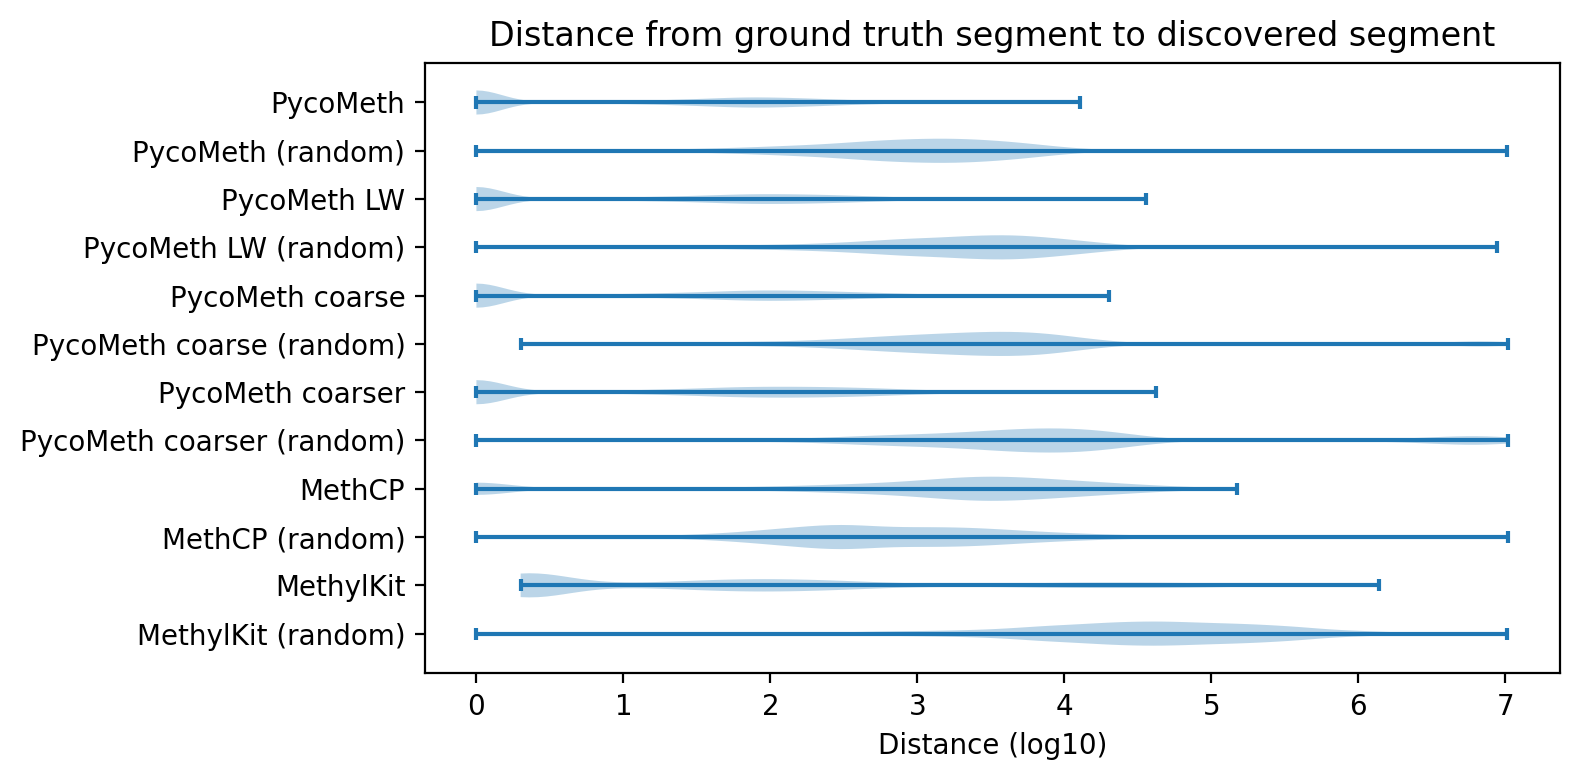

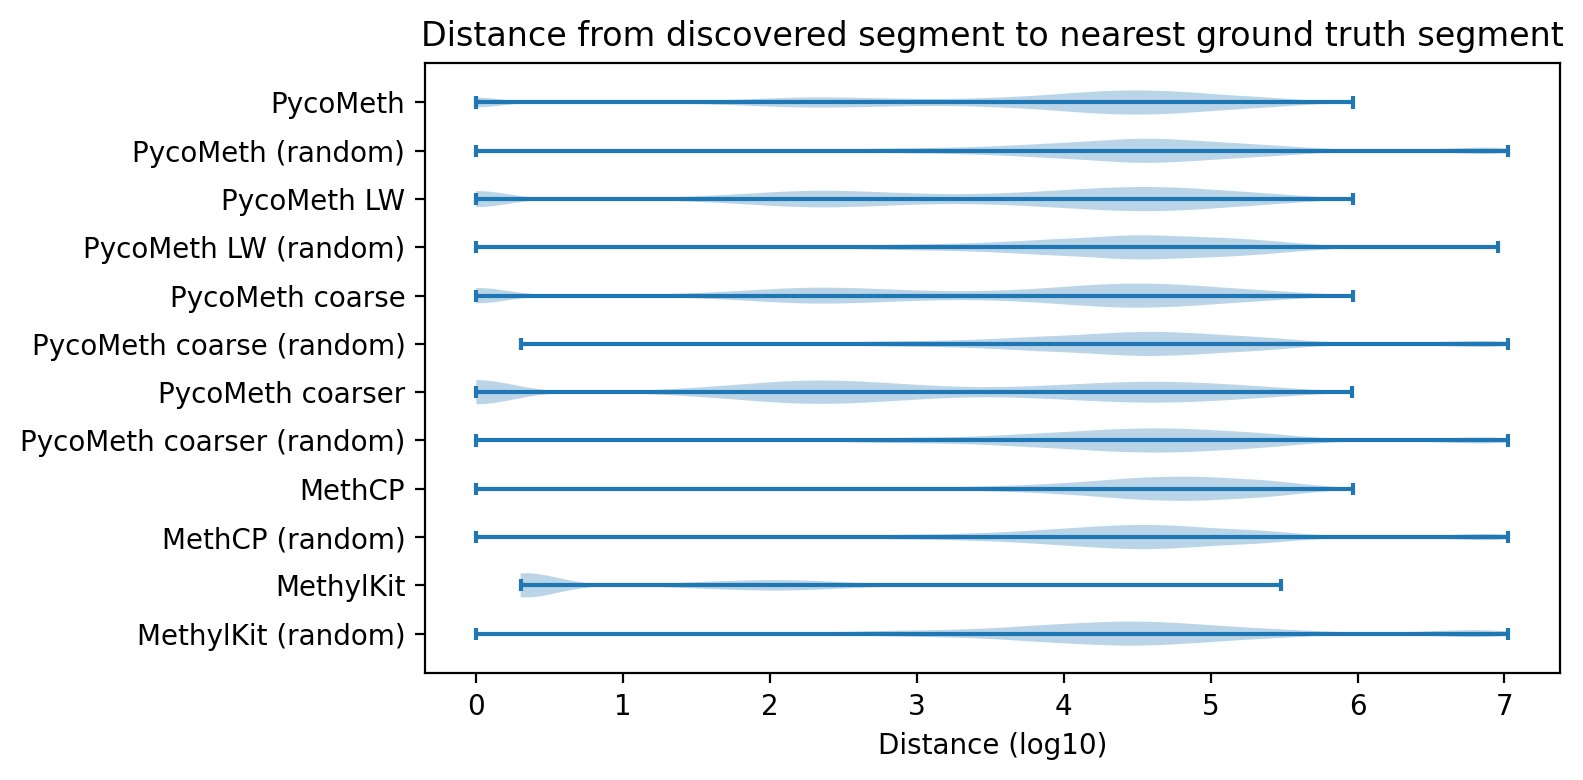

In [6]:
pa.figure(figsize=(8,4))
tools = list(all_dists_from_gt.keys())[::-1]
x = np.arange(len(tools))
plt.violinplot([np.log10(all_dists_from_gt[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from ground truth segment to discovered segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_disc_to_gt_15x")

pa.figure(figsize=(8,4))
plt.violinplot([np.log10(all_dists_from_pred[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from discovered segment to nearest ground truth segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_gt_to_disc_15x")

In [7]:
sc.gt_segments = gt_only_diffmet
all_dists_from_gt_gtonly = sc.compute_gt_dist_to_all_predicted()
all_dists_from_pred_gtonly = sc.compute_predicted_dist_to_all_gt()

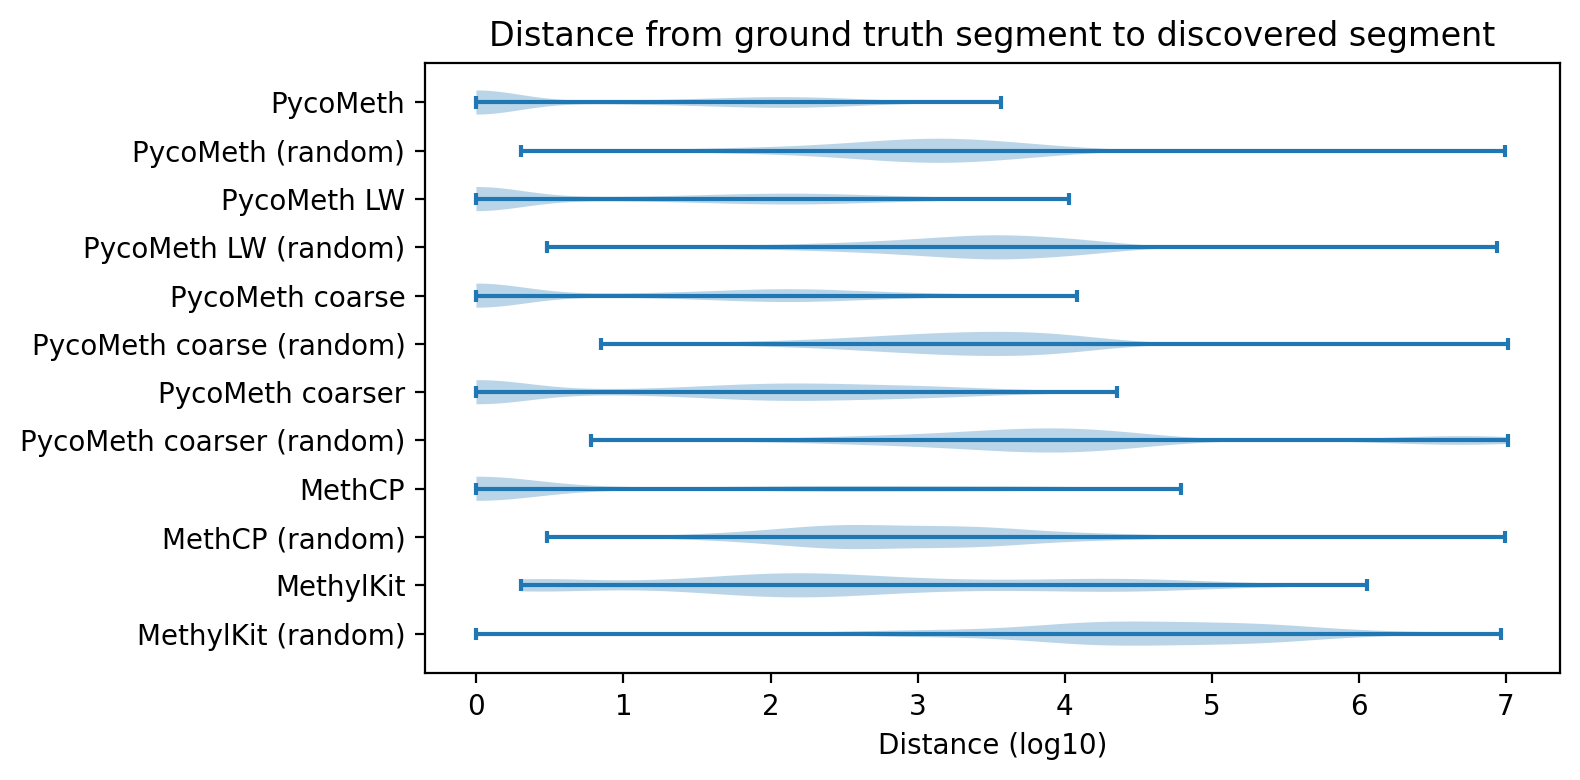

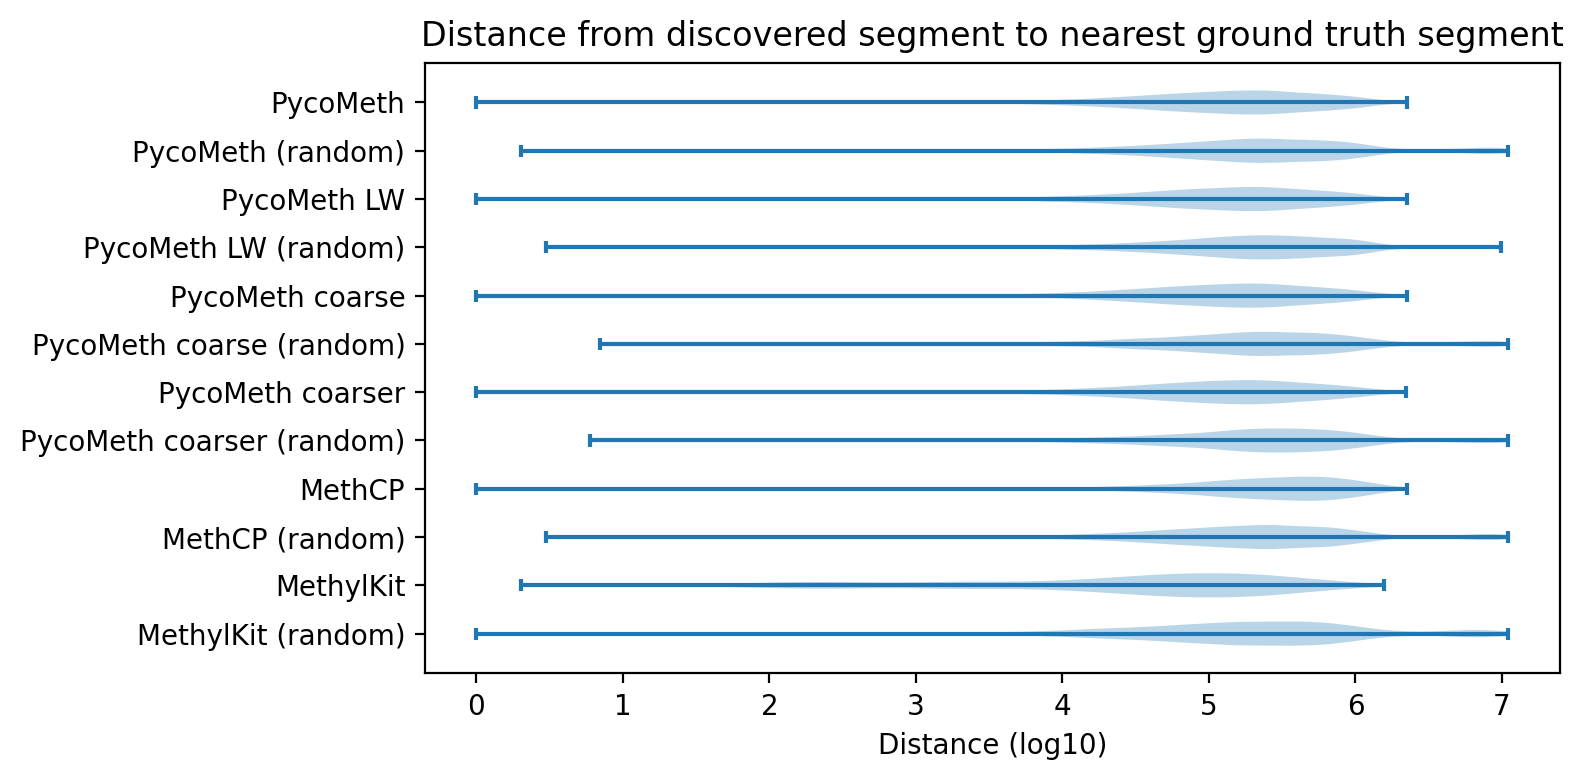

In [8]:
pa.figure(figsize=(8,4))
tools = list(all_dists_from_gt.keys())[::-1]
x = np.arange(len(tools))
plt.violinplot([np.log10(all_dists_from_gt_gtonly[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from ground truth segment to discovered segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_disc_to_gt_onlygt_15x")

pa.figure(figsize=(8,4))
plt.violinplot([np.log10(all_dists_from_pred_gtonly[tool]+1) for tool in tools], positions=x, vert=False)
plt.yticks(x, tools)
plt.title("Distance from discovered segment to nearest ground truth segment")
plt.xlabel("Distance (log10)")
pa.saveandshow("dist_gt_to_disc_onlygt_15x")


In [37]:
sc.gt_segments = gt

leftover_segments = {}
for tool in sc.predicted_segments:
    if "random" in tool:
        continue
    leftover_segments[tool] = sc.count_segments_identified(tool)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4941/4941 [00:31<00:00, 154.93it/s]


In [38]:
def count_leftover_segments(leftover, cps_not_used):
    counts = {}
    found = gt.drop(leftover.index)
    counts["Diffmet found"] = (found["theta"] != 0).sum()
    counts["Found"] = (found["theta"] == 0).sum()
    idx_leftover_diffmet = leftover["theta"] != 0
    counts["Diffmet one end"] = leftover.loc[idx_leftover_diffmet]["found_right"].sum() + leftover.loc[idx_leftover_diffmet]["found_left"].sum()
    counts["One end"] = leftover["found_right"].sum() + leftover["found_left"].sum() - counts["Diffmet one end"]

    counts["Diffmet not found"] = idx_leftover_diffmet.sum() - counts["Diffmet one end"]
    counts["Not found"] = (~idx_leftover_diffmet).sum() - counts["One end"]

    counts["Additional CPs"] = 0
    for a, b in zip(tqdm.tqdm(cps_not_used), cps_not_used[1:]):
        # this might be the same changepoint (just end and start merged)
        cgs = reference_cpgs.get_CGs("1", a+1, b-1)
        if len(cgs) > 0:
            counts["Additional CPs"] += 1

    return counts

tool_found_counts = {tool: count_leftover_segments(*leftover_segments[tool]) for tool in leftover_segments}

tool_found_counts["GT"]={"Diffmet found": len(gt_only_diffmet),
                         "Found": len(gt)-len(gt_only_diffmet)}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2621/2622 [00:17<00:00, 152.76it/s]


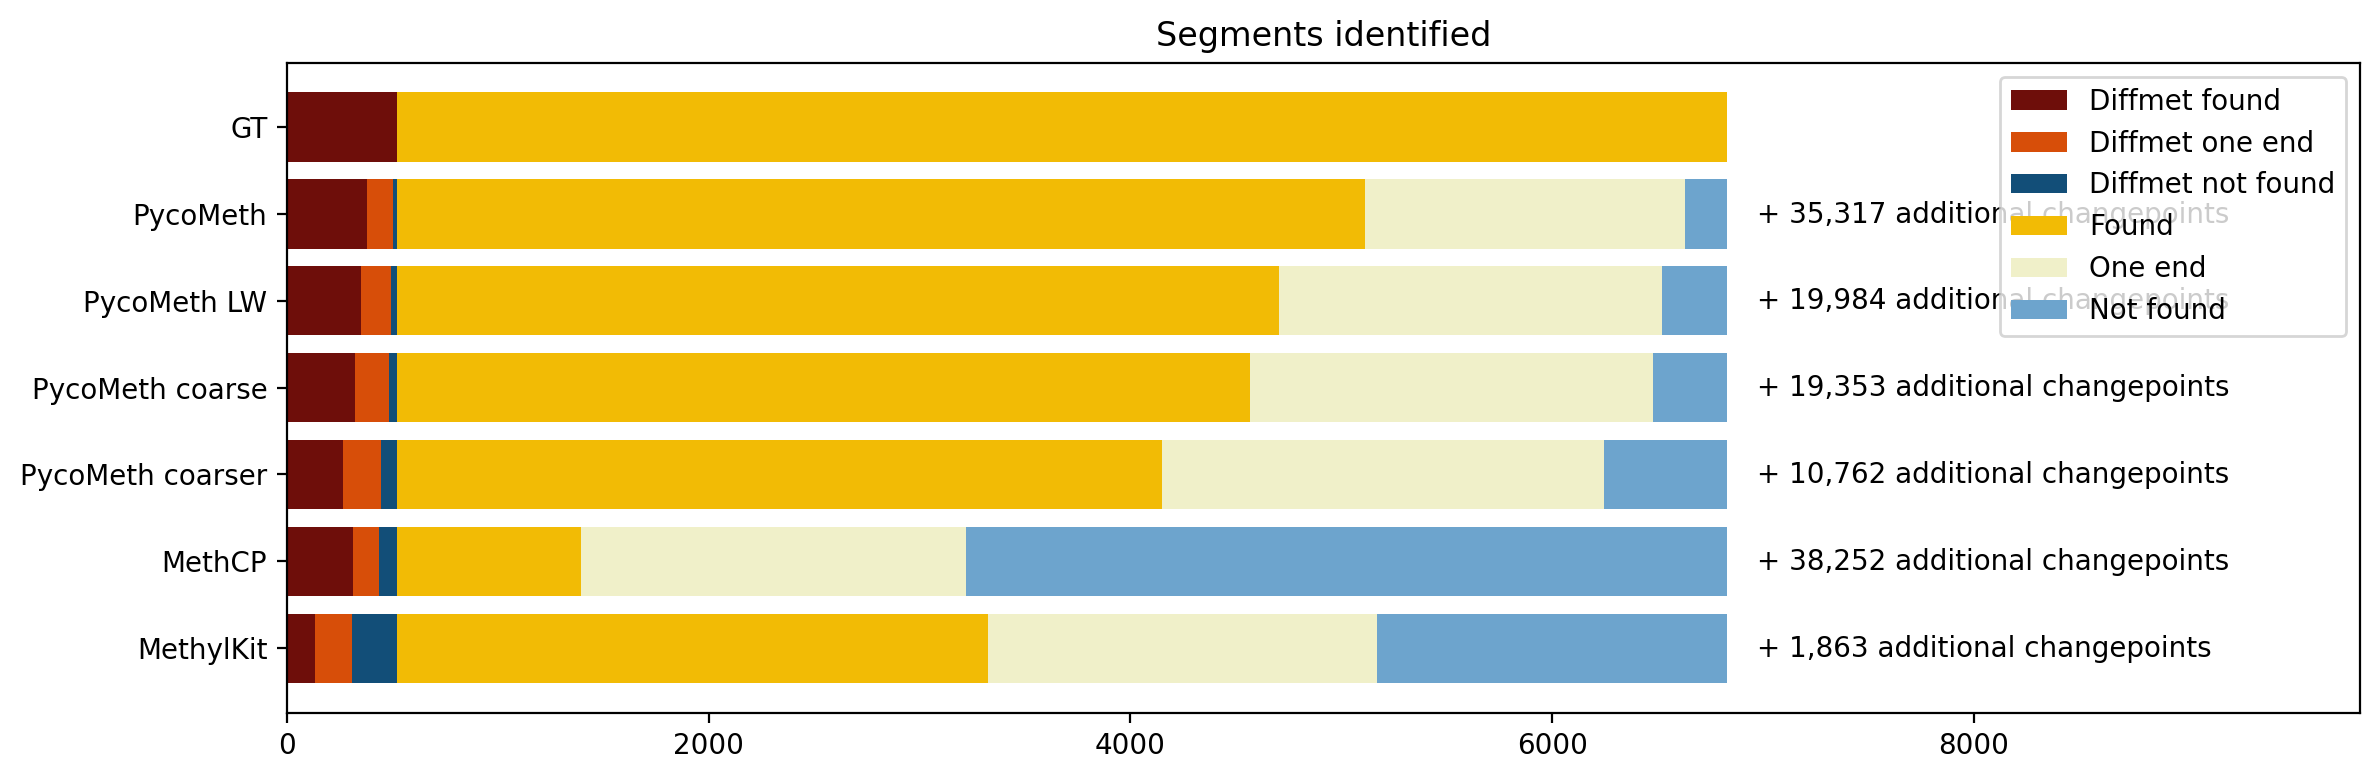

In [40]:
pa.figure(figsize=(12,4))
tools = ["GT", "PycoMeth", "PycoMeth LW", "PycoMeth coarse", "PycoMeth coarser", "MethCP", "MethylKit"][::-1]
label_order = ["Diffmet found", "Diffmet one end", "Diffmet not found", "Found", "One end", "Not found"]#, "Additional CPs"]
colors = {"Diffmet found":"#6E0E0A", "Diffmet one end":"#D74E09", "Found":"#F2BB05", "One end":"#F0F0C9", "Diffmet not found":"#124E78", "Not found": "#6da4cd", "Additional CPs": "gray"}
bottom = [0 for _ in tools]
for label in label_order:
    h = [tool_found_counts[tool].get(label, 0) for tool in tools]
    plt.barh(tools, h, left=bottom, label=label, color=colors[label])
    bottom = [b+hi for b,hi in zip(bottom, h)]
xmax = plt.xlim()[1]
plt.xlim(0, xmax+3000)
for i, tool in enumerate(tools):
    if tool == "GT":
        continue
    a_cp = tool_found_counts[tool]["Additional CPs"]
    plt.text(xmax+100, i-0.1, f" + {a_cp:,} additional changepoints")

plt.title("Segments identified")
#plt.ylim(-0.5, len(tools)+1)
plt.legend()
pa.saveandshow("segments_correctly_found_15x")